In [41]:
import pandas as pd # Pour le dataframe
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN

import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

# Dataset pre-processing

In [42]:
Crema = "C:/Users/julia/Desktop/5A/FinalProject/AudioWAV/AudioWAV/"

In [43]:
crema_directory_list = os.listdir(Crema)

In [44]:
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema+file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':  
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
1,disgust,C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
2,fear,C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
3,happy,C:/Users/julia/Desktop/5A/FinalProject/AudioWA...
4,neutral,C:/Users/julia/Desktop/5A/FinalProject/AudioWA...


In [71]:
#récupére les vecteur de chaque son qu'on utilisera dans nos features plus tard 
VectAudio = []
for audio in Crema_df['Path']:
    #print(audio)
    data, sampling_frequency = librosa.load(audio)
    VectAudio.append(data)
    

KeyboardInterrupt: 

In [72]:
len(VectAudio)

727

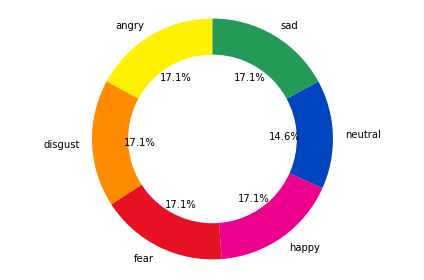

In [46]:
y = Crema_df['Emotions']
values = np.unique(y,return_counts=True)[1]

Classes=np.unique(Crema_df["Emotions"])
labels = Classes
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c','#0044bf',"#239B56"]
 
# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')  
plt.tight_layout()
plt.show()

## Extract features

In [65]:
#récupére les vecteur de chaque son qu'on utilisera dans nos features plus tard 
VectAudio = {'audio_name':[],'val_audio':[]}
for audio in Crema_df['Path']:
    #print(audio)
    data, sampling_frequency = librosa.load(audio)
    #print(data)
    VectAudio['val_audio'].append(data)
    VectAudio['audio_name'].append((str(audio)[57:-4]))

KeyboardInterrupt: 

In [66]:
len(audio)

76

In [55]:
def audio_pipeline(audio):

    features = []

  # Calcul du ZCR

    zcr = librosa.zero_crossings(audio)
    features.append(sum(zcr))

  # Calcul de la moyenne du Spectral centroid

    spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
    features.append(np.mean(spectral_centroids))
  
  # Calcul du spectral rolloff point

    rolloff = librosa.feature.spectral_rolloff(audio)
    features.append(np.mean(rolloff))

  # Calcul des moyennes des MFCC

    mfcc = librosa.feature.mfcc(audio)

    for x in mfcc:
        features.append(np.mean(x))

    return features

In [56]:
column_names = ['zcr', 'spectral_c', 'rolloff', 'mfcc1', 'mfcc2', 'mfcc3',
                'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
                'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
                'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20']
len(column_names)

23

In [67]:
Features = []
for audio in VectAudio['val_audio']:
    #print(audio)
    Features.append(audio_pipeline(audio))

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0711522e-05
  2.0702407e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 6.5432931e-03  7.1702655e-03  5.0253877e-03 ... -3.4195062e-05
 -2.4404479e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 6.5432931e-03  7.1702655e-03  5.0253877e-03 ... -3.4195062e-05
 -2.4404479e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 6.5432931e-03  7.1702655e-03  5.0253877e-03 ... -3.4195062e-05
 -2.4404479e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-6.7129564e-03 -7.0502055e-03 -5.8192955e-03 ...  3.1441150e-10
 -1.9900764e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-6.7129564e-03 -7.0502055e-03 -5.8192955e-03 ...  3.1441150e-10
 -1.9900764e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-6.7129564e-03 -7.0502055e-03 -5.8192955e-03 ...  3.1441150e-10
 -1.9900764e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.0044777  -0.00481995 -0.00397186 ... -0.00017448 -0.00013711
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.0044777  -0.00481995 -0.00397186 ... -0.00017448 -0.00013711
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.0044777  -0.00481995 -0.00397186 ... -0.00017448 -0.00013711
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-1.8941269e-03 -1.3840066e-03 -1.6259517e-04 ...  8.8784304e-09
 -7.4632291e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-1.8941269e-03 -1.3840066e-03 -1.6259517e-04 ...  8.8784304e-09
 -7.4632291e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-1.8941269e-03 -1.3840066e-03 -1.6259517e-04 ...  8.8784304e-09
 -7.4632291e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.00137359 0.00219618 0.00241108 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.00137359 0.00219618 0.00241108 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.00137359 0.00219618 0.00241108 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-2.3884645e-03 -2.6558416e-03 -1.9455150e-03 ... -7.0478701e-10
  4.7806781e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-2.3884645e-03 -2.6558416e-03 -1.9455150e-03 ... -7.0478701e-10
  4.7806781e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-2.3884645e-03 -2.6558416e-03 -1.9455150e-03 ... -7.0478701e-10
  4.7806781e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-5.6039016e-03 -6.6844202e-03 -5.5854353e-03 ...  2.5955369e-05
  5.4505872e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-5.6039016e-03 -6.6844202e-03 -5.5854353e-03 ...  2.5955369e-05
  5.4505872e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-5.6039016e-03 -6.6844202e-03 -5.5854353e-03 ...  2.5955369e-05
  5.4505872e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[2.5689115e-03 2.7619312e-03 2.4131779e-03 ... 1.9985966e-06 4.3366154e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[2.5689115e-03 2.7619312e-03 2.4131779e-03 ... 1.9985966e-06 4.3366154e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[2.5689115e-03 2.7619312e-03 2.4131779e-03 ... 1.9985966e-06 4.3366154e-07
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\juli

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 1.0463956e-02  1.1218210e-02  8.9831874e-03 ...  3.7411397e-07
 -1.2941620e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 1.0463956e-02  1.1218210e-02  8.9831874e-03 ...  3.7411397e-07
 -1.2941620e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 1.0463956e-02  1.1218210e-02  8.9831874e-03 ...  3.7411397e-07
 -1.2941620e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-5.6168991e-03 -5.9620617e-03 -5.0622085e-03 ...  1.1032289e-06
 -2.9711513e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-5.6168991e-03 -5.9620617e-03 -5.0622085e-03 ...  1.1032289e-06
 -2.9711513e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-5.6168991e-03 -5.9620617e-03 -5.0622085e-03 ...  1.1032289e-06
 -2.9711513e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00168894 -0.00223646 -0.00230612 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00168894 -0.00223646 -0.00230612 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00168894 -0.00223646 -0.00230612 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[4.8385598e-03 5.2356310e-03 3.9224662e-03 ... 1.8802616e-04 6.9630420e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[4.8385598e-03 5.2356310e-03 3.9224662e-03 ... 1.8802616e-04 6.9630420e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[4.8385598e-03 5.2356310e-03 3.9224662e-03 ... 1.8802616e-04 6.9630420e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\juli

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.00998455 0.01093859 0.00922983 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.00998455 0.01093859 0.00922983 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.00998455 0.01093859 0.00922983 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-4.1047097e-04 -4.6002428e-04 -5.4921809e-04 ... -9.0383975e-05
 -5.8870854e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-4.1047097e-04 -4.6002428e-04 -5.4921809e-04 ... -9.0383975e-05
 -5.8870854e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-4.1047097e-04 -4.6002428e-04 -5.4921809e-04 ... -9.0383975e-05
 -5.8870854e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-7.7728491e-04 -6.7717384e-04 -4.0894857e-04 ... -1.3447389e-05
 -3.5843248e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-7.7728491e-04 -6.7717384e-04 -4.0894857e-04 ... -1.3447389e-05
 -3.5843248e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-7.7728491e-04 -6.7717384e-04 -4.0894857e-04 ... -1.3447389e-05
 -3.5843248e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-5.8335369e-03 -6.7455219e-03 -5.6679524e-03 ... -1.2869091e-04
 -9.4056631e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-5.8335369e-03 -6.7455219e-03 -5.6679524e-03 ... -1.2869091e-04
 -9.4056631e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-5.8335369e-03 -6.7455219e-03 -5.6679524e-03 ... -1.2869091e-04
 -9.4056631e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-4.4800290e-03 -4.9055074e-03 -3.4517981e-03 ...  2.1315101e-04
  8.6044085e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-4.4800290e-03 -4.9055074e-03 -3.4517981e-03 ...  2.1315101e-04
  8.6044085e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-4.4800290e-03 -4.9055074e-03 -3.4517981e-03 ...  2.1315101e-04
  8.6044085e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-1.9890373e-03 -2.9217966e-03 -3.1536012e-03 ... -2.4415971e-07
  2.0281359e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-1.9890373e-03 -2.9217966e-03 -3.1536012e-03 ... -2.4415971e-07
  2.0281359e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-1.9890373e-03 -2.9217966e-03 -3.1536012e-03 ... -2.4415971e-07
  2.0281359e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.0019394  0.00132665 0.00087011 ... 0.0001293  0.0001704  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.0019394  0.00132665 0.00087011 ... 0.0001293  0.0001704  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.0019394  0.00132665 0.00087011 ... 0.0001293  0.0001704  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00218863 -0.00204798 -0.00156148 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00218863 -0.00204798 -0.00156148 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00218863 -0.00204798 -0.00156148 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-1.8785187e-03 -1.9315444e-03 -1.7764296e-03 ... -4.9492108e-09
  7.1752360e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-1.8785187e-03 -1.9315444e-03 -1.7764296e-03 ... -4.9492108e-09
  7.1752360e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-1.8785187e-03 -1.9315444e-03 -1.7764296e-03 ... -4.9492108e-09
  7.1752360e-10  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 9.9234888e-04  1.0708336e-03  1.4246937e-03 ... -3.9175768e-05
 -2.9571696e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 9.9234888e-04  1.0708336e-03  1.4246937e-03 ... -3.9175768e-05
 -2.9571696e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 9.9234888e-04  1.0708336e-03  1.4246937e-03 ... -3.9175768e-05
 -2.9571696e-05  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-1.1136352e-02 -1.2710372e-02 -1.0635146e-02 ...  4.0867570e-05
 -2.2889388e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-1.1136352e-02 -1.2710372e-02 -1.0635146e-02 ...  4.0867570e-05
 -2.2889388e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-1.1136352e-02 -1.2710372e-02 -1.0635146e-02 ...  4.0867570e-05
 -2.2889388e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[7.6208338e-03 8.3018783e-03 6.9427495e-03 ... 8.9016707e-05 5.2332925e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[7.6208338e-03 8.3018783e-03 6.9427495e-03 ... 8.9016707e-05 5.2332925e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[7.6208338e-03 8.3018783e-03 6.9427495e-03 ... 8.9016707e-05 5.2332925e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\juli

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00408582 -0.00466754 -0.00384783 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00408582 -0.00466754 -0.00384783 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00408582 -0.00466754 -0.00384783 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-7.1080256e-05  4.9342489e-04  1.3804955e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-7.1080256e-05  4.9342489e-04  1.3804955e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-7.1080256e-05  4.9342489e-04  1.3804955e-03 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 3.9607431e-03  4.3068170e-03  3.3803300e-03 ...  3.1557121e-08
 -6.3765064e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 3.9607431e-03  4.3068170e-03  3.3803300e-03 ...  3.1557121e-08
 -6.3765064e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 3.9607431e-03  4.3068170e-03  3.3803300e-03 ...  3.1557121e-08
 -6.3765064e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 2.3884470e-04  4.1082906e-04  9.7827567e-04 ... -3.6559094e-08
  1.2278136e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 2.3884470e-04  4.1082906e-04  9.7827567e-04 ... -3.6559094e-08
  1.2278136e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 2.3884470e-04  4.1082906e-04  9.7827567e-04 ... -3.6559094e-08
  1.2278136e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.00029047 0.00042843 0.00089239 ... 0.00085274 0.00070164 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.00029047 0.00042843 0.00089239 ... 0.00085274 0.00070164 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.00029047 0.00042843 0.00089239 ... 0.00085274 0.00070164 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00197084 -0.0023985  -0.00256691 ... -0.03566182 -0.0223454
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00197084 -0.0023985  -0.00256691 ... -0.03566182 -0.0223454
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00197084 -0.0023985  -0.00256691 ... -0.03566182 -0.0223454
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\262

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00241283 -0.00315789 -0.00279506 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00241283 -0.00315789 -0.00279506 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00241283 -0.00315789 -0.00279506 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.01118745 0.01269777 0.01096787 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.01118745 0.01269777 0.01096787 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.01118745 0.01269777 0.01096787 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.00421035 0.00453868 0.00343092 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.00421035 0.00453868 0.00343092 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.00421035 0.00453868 0.00343092 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00259871 -0.00306972 -0.00258929 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00259871 -0.00306972 -0.00258929 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00259871 -0.00306972 -0.00258929 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 1.1830136e-04 -1.5573693e-04 -9.0595859e-05 ...  1.6005691e-08
 -8.8590042e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 1.1830136e-04 -1.5573693e-04 -9.0595859e-05 ...  1.6005691e-08
 -8.8590042e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 1.1830136e-04 -1.5573693e-04 -9.0595859e-05 ...  1.6005691e-08
 -8.8590042e-09  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 3.3573192e-03  3.7397675e-03  2.8384952e-03 ... -9.3628762e-05
 -1.5647504e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 3.3573192e-03  3.7397675e-03  2.8384952e-03 ... -9.3628762e-05
 -1.5647504e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 3.3573192e-03  3.7397675e-03  2.8384952e-03 ... -9.3628762e-05
 -1.5647504e-04  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[0.00071369 0.00195413 0.00205403 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[0.00071369 0.00195413 0.00205403 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[0.00071369 0.00195413 0.00205403 ... 0.         0.         0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Fut

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00051792 -0.00077921 -0.00117136 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00051792 -0.00077921 -0.00117136 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00051792 -0.00077921 -0.00117136 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-6.5666069e-03 -8.3452892e-03 -7.8105675e-03 ...  7.2332402e-09
 -2.3450411e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-6.5666069e-03 -8.3452892e-03 -7.8105675e-03 ...  7.2332402e-09
 -2.3450411e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-6.5666069e-03 -8.3452892e-03 -7.8105675e-03 ...  7.2332402e-09
 -2.3450411e-07  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[ 7.9632746e-03  9.3680415e-03  8.0977911e-03 ...  2.2959384e-05
 -1.1709102e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[ 7.9632746e-03  9.3680415e-03  8.0977911e-03 ...  2.2959384e-05
 -1.1709102e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[ 7.9632746e-03  9.3680415e-03  8.0977911e-03 ...  2.2959384e-05
 -1.1709102e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(au

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[-0.00121317 -0.00136592 -0.00091696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[-0.00121317 -0.00136592 -0.00091696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[-0.00121317 -0.00136592 -0.00091696 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: Future

C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:12: FutureWarning: Pass y=[6.3535986e-03 7.3586442e-03 6.6146408e-03 ... 2.3559507e-04 6.7517940e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(audio)[0]
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:17: FutureWarning: Pass y=[6.3535986e-03 7.3586442e-03 6.6146408e-03 ... 2.3559507e-04 6.7517940e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  rolloff = librosa.feature.spectral_rolloff(audio)
C:\Users\julia\AppData\Local\Temp\ipykernel_3192\2622758444.py:22: FutureWarning: Pass y=[6.3535986e-03 7.3586442e-03 6.6146408e-03 ... 2.3559507e-04 6.7517940e-05
 0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(audio)
C:\Users\juli

KeyboardInterrupt: 

In [68]:
df = pd.DataFrame(Features,columns = column_names)
df

,zcr,spectral_c,rolloff,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,3869,1461.694394,2909.266246,-344.070160,123.578468,-12.137379,41.177151,-2.905606,13.556086,-17.609064,...,-8.872458,-4.396894,-1.333274,-14.977488,8.471259,-12.354980,-8.076804,-2.281948,-4.057670,-6.480635
1,3531,1405.486665,2775.224803,-391.156952,137.478500,-20.730135,55.133484,-1.362616,22.416723,-22.356289,...,-5.408142,-8.455474,2.169044,-15.388247,5.788134,-15.657177,-3.936530,-3.040118,-4.708966,-6.222461
2,2929,1367.736440,2738.152946,-353.697144,117.784874,-5.076811,34.020809,4.950703,11.070600,-16.034912,...,-10.291203,-6.693974,-2.282563,-12.420956,2.749392,-11.476346,-6.374039,-4.596244,-5.187902,-6.659904
3,2618,1431.879649,2894.487847,-339.766388,122.683655,-14.825016,41.138290,3.803923,9.775388,-20.466356,...,-12.417223,-5.156795,-0.899664,-16.725868,5.066189,-12.094768,-7.267103,-3.397402,-4.444639,-6.497626
4,2741,1372.732514,2818.402654,-370.031586,126.838776,-6.678929,40.750210,6.421874,12.087253,-11.939016,...,-7.585192,-3.032992,-2.357732,-11.126751,6.953789,-11.519061,-6.573707,-3.362730,-5.004889,-3.369909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,3756,1331.893042,2636.897160,-421.795746,147.826584,-11.854547,44.367065,-8.687526,27.428549,-19.174801,...,-0.569157,-5.959120,-0.845538,-16.390293,5.552438,-10.173388,-4.294960,-12.536510,-2.100742,-1.170892
378,3317,1375.831321,2764.884601,-423.258240,156.069336,-21.813498,51.467808,-16.285189,35.754681,-21.412418,...,0.032990,-6.083757,0.965568,-17.685814,7.743306,-14.817337,-0.648181,-12.216791,-2.600906,-2.251378
379,5310,1368.739789,2648.920441,-350.978668,120.168350,-2.562594,30.558033,0.077404,4.250730,-10.144905,...,-6.707667,-5.946947,-0.929188,-11.196600,-0.541377,-8.856520,-6.196424,-9.919348,-4.607347,-3.942767
380,4976,1272.924734,2447.121869,-401.246704,143.058380,-7.948252,42.140285,-7.125478,19.677328,-16.580887,...,-5.623178,-3.527689,1.583831,-16.388395,3.733648,-11.367097,-4.377688,-8.385484,-4.544802,-2.682132


In [69]:
df = df.assign(name=VectAudio['audio_name'])
df.head()

ValueError: Length of values (3225) does not match length of index (382)

In [ ]:
df = df.sort_values(by = 'name')
df.reset_index(inplace=True)
df = df.assign(Mediane=dataNote['Emotions'])

## Split Data 


In [ ]:
X = df[column_names]#features 
y = df['Emotions']#label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

## Features importances